In [60]:
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.datasets import load_digits
from sklearn.metrics import confusion_matrix
from sklearn import metrics
%matplotlib inline

In [61]:
#################### K-Means on Handwritten Digits Dataset ####################

In [62]:
X, y = load_digits(return_X_y=True)

In [63]:
from scipy.spatial import distance
from sklearn.preprocessing import StandardScaler

X = PCA(n_components=2).fit_transform(X)


def kmeans(X, k=10, max_iterations=100):
    if isinstance(X, pd.DataFrame): X = X.values
    idx = np.random.choice(len(X), k, replace=False)
    centroids = X[idx, :]
    P = np.argmin(distance.cdist(X, centroids, 'euclidean'), axis=1)
    for _ in range(max_iterations):
        centroids = np.vstack([X[P == i, :].mean(axis=0) for i in range(k)])
        tmp = np.argmin(distance.cdist(X, centroids, 'euclidean'), axis=1)
        if np.array_equal(P, tmp): break # if the position of the centroids
        P = tmp
    return P


y_predicted = kmeans(X)

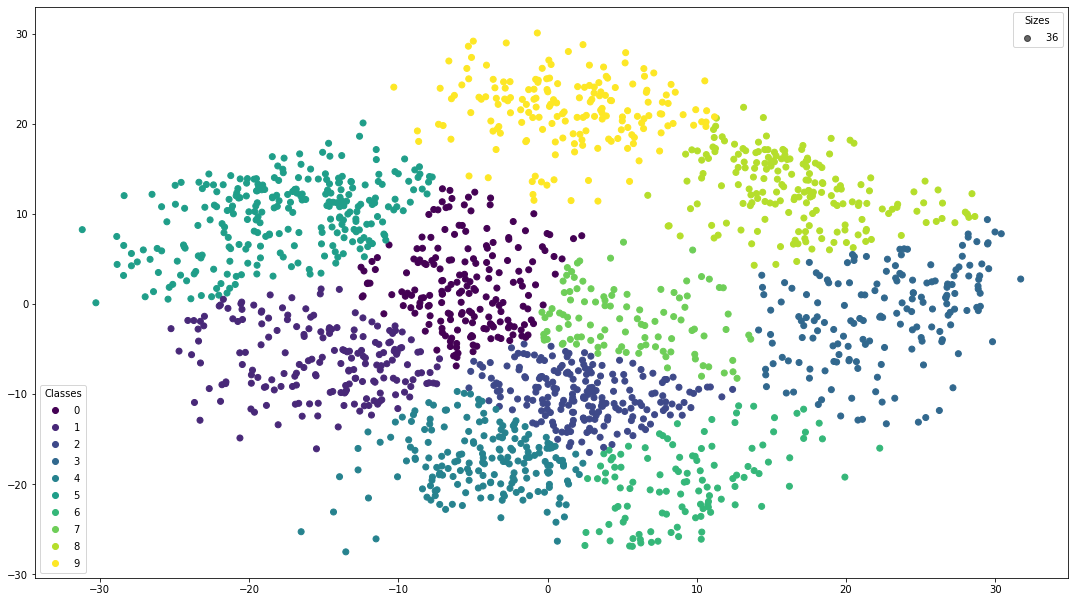

In [64]:
fig, ax = plt.subplots()
fig.set_size_inches(18.5, 10.5)

scatter = ax.scatter(X[:, 0], X[:, 1], c=y_predicted)

# produce a legend with the unique colors from the scatter
legend1 = ax.legend(*scatter.legend_elements(),
                    loc="lower left", title="Classes")
ax.add_artist(legend1)

# produce a legend with a cross section of sizes from the scatter
handles, labels = scatter.legend_elements(prop="sizes", alpha=0.6)
legend2 = ax.legend(handles, labels, loc="upper right", title="Sizes")

plt.show()

In [65]:
confusion_matrix(y, y_predicted)

array([[  2,   0,   0,   1,   0,   1,   0,   0,  13, 161],
       [ 26,   0,  41,   2,   9,   1,  86,  16,   0,   1],
       [ 32, 111,  19,   0,  11,   3,   0,   1,   0,   0],
       [ 12,  63,   0,   0,  13,  95,   0,   0,   0,   0],
       [  0,   0,   2, 144,   3,   0,   5,   3,  24,   0],
       [ 39,   4,  43,   1,  19,  37,   0,  29,   4,   6],
       [  0,   0,   0,  20,   0,   0,   0,   4, 149,   8],
       [  1,   0,  44,   1, 104,   0,  20,   9,   0,   0],
       [ 62,   3,  53,   1,  22,   0,   3,  30,   0,   0],
       [ 19,   8,   5,   0,   7, 129,   0,  12,   0,   0]])

In [67]:
print(metrics.fowlkes_mallows_score(y, y_predicted))

0.4544661044794445


In [57]:
#################### Agglomerative Clustering on Handwritten Digits Dataset ####################

In [83]:
from time import time
import numpy as np
from scipy import ndimage
from matplotlib import pyplot as plt
from sklearn import manifold, datasets, metrics

In [84]:
X, y = datasets.load_digits(return_X_y=True)
n_samples, n_features = X.shape

In [85]:
np.random.seed(0)

In [86]:
def nudge_images(X, y):
    shift = lambda x: ndimage.shift(
        x.reshape((8, 8)), 0.3 * np.random.normal(size=2), mode="constant"
    ).ravel()
    X = np.concatenate([X, np.apply_along_axis(shift, 1, X)])
    Y = np.concatenate([y, y], axis=0)
    return X, Y

In [87]:
X, y = nudge_images(X, y)

In [88]:
# Visualize the clustering
def plot_clustering(X_red, labels, title=None):
    x_min, x_max = np.min(X_red, axis=0), np.max(X_red, axis=0)
    X_red = (X_red - x_min) / (x_max - x_min)

    plt.figure(figsize=(6, 4))
    for i in range(X_red.shape[0]):
        plt.text(
            X_red[i, 0],
            X_red[i, 1],
            str(y[i]),
            color=plt.cm.nipy_spectral(labels[i] / 10.0),
            fontdict={"weight": "bold", "size": 9},
        )

    plt.xticks([])
    plt.yticks([])
    if title is not None:
        plt.title(title, size=17)
    plt.axis("off")
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])

In [89]:
# 2D embedding of the digits dataset
print("Computing embedding")
X_red = manifold.SpectralEmbedding(n_components=2).fit_transform(X)
print("Done.")

Computing embedding
Done.


ward :	0.28s


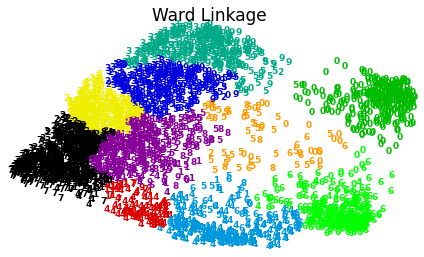

In [90]:
clustering = AgglomerativeClustering(linkage="ward", n_clusters=10)
t0 = time()
clustering.fit(X_red)
print("%s :\t%.2fs" % ("ward", time() - t0))

plot_clustering(X_red, clustering.labels_, "%s Linkage" % "Ward")

plt.show()

In [92]:
X, y = load_digits(return_X_y=True)
y_predicted = clustering.fit_predict(X)

In [93]:
confusion_matrix(y, y_predicted)
print(metrics.fowlkes_mallows_score(y, y_predicted))

0.8167516860736177


In [94]:
#################### Affinity Propagation on Handwritten Digits Dataset ####################

In [95]:
from sklearn.cluster import AffinityPropagation
from sklearn import metrics
from sklearn.model_selection import train_test_split

In [96]:
# Generate sample data
X, y = load_digits(return_X_y=True)

X_train, X_test, y_train, y_test = train_test_split(
     X, y, test_size=0.04, random_state=42)

In [97]:
# Compute Affinity Propagation
af = AffinityPropagation( )

y_predictions = af.fit(X_train, y_train).fit_predict(X_test)
cluster_centers_indices = af.cluster_centers_indices_

n_clusters_ = len(cluster_centers_indices)

print("Estimated number of clusters: %d" % n_clusters_)
print("Fowkles-Mallows measure: %0.3f" % metrics.fowlkes_mallows_score(y_test, y_predictions))

Estimated number of clusters: 11
Fowkles-Mallows measure: 0.778


64


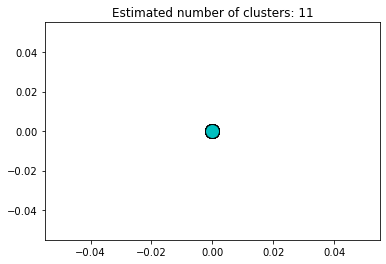

In [98]:
# Plot result
import matplotlib.pyplot as plt
from itertools import cycle

plt.close("all")
plt.figure(1)
plt.clf()

colors = cycle("bgrcmykbgrcmykbgrcmykbgrcmyk")
for k, col in zip(range(n_clusters_), colors):
    class_members = labels == k
    cluster_center = X_test[cluster_centers_indices[k]]
    
    plt.plot(X_test[class_members, 0], X_test[class_members, 1], col + ".")
    plt.plot(
        cluster_center[0],
        cluster_center[1],
        "o",
        markerfacecolor=col,
        markeredgecolor="k",
        markersize=14,
    )
    for x in X_test[class_members]:
        plt.plot([cluster_center[0], x[0]], [cluster_center[1], x[1]], col)

print(len(cluster_center))
plt.title("Estimated number of clusters: %d" % n_clusters_)
plt.show()

In [99]:
confusionMatrix = metrics.confusion_matrix(y_test, y_predictions)
print(confusionMatrix)
print(metrics.fowlkes_mallows_score(y_test, y_predictions))

[[0 0 0 7 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 6 1 0]
 [0 1 0 0 4 0 0 0 0 0 0]
 [0 7 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 9 0 0 0 0]
 [0 0 7 0 0 0 0 0 0 1 3]
 [0 0 0 0 0 0 0 9 0 0 0]
 [0 0 1 0 0 5 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 1]
 [4 0 0 0 0 0 0 0 0 4 1]
 [0 0 0 0 0 0 0 0 0 0 0]]
0.7776050538582544


In [101]:
# from sklearn.model_selection import GridSearchCV

In [102]:
# parameters = {'damping':[x / 100.0 for x in range(50, 100, 1)], 'convergence_iter':[x for x in range(1, 170, 1)]}
# clf = GridSearchCV(af, parameters, scoring='accuracy')

In [ ]:
# clf.fit(X_train, y_train)

In [ ]:
# sorted(clf.cv_results_.keys())

In [105]:
# def doAffinity(X):
#     model = AffinityPropagation()
#     model.fit(X)
#     clust_labels2 = model.predict(X)
#     cent2 = model.cluster_centers_
#     return (clust_labels2, cent2)

# ss = StandardScaler()
# ss.fit_transform(X)

# clust_labels2, cent2 = doAffinity(X[:,:200])
# affinity = pd.DataFrame(y)

# n_clusters_ = len(cent2)

# print("Estimated number of clusters: %d" % n_clusters_)
# print("Fowkles-Mallows measure: %0.3f" % metrics.fowlkes_mallows_score(y_test, y_predictions))